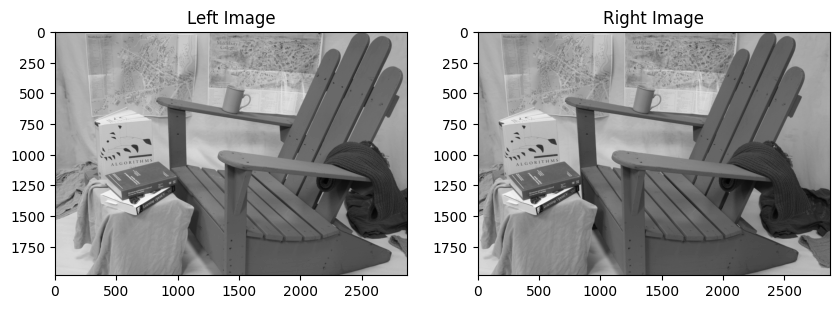

Number of good matches: 1250308


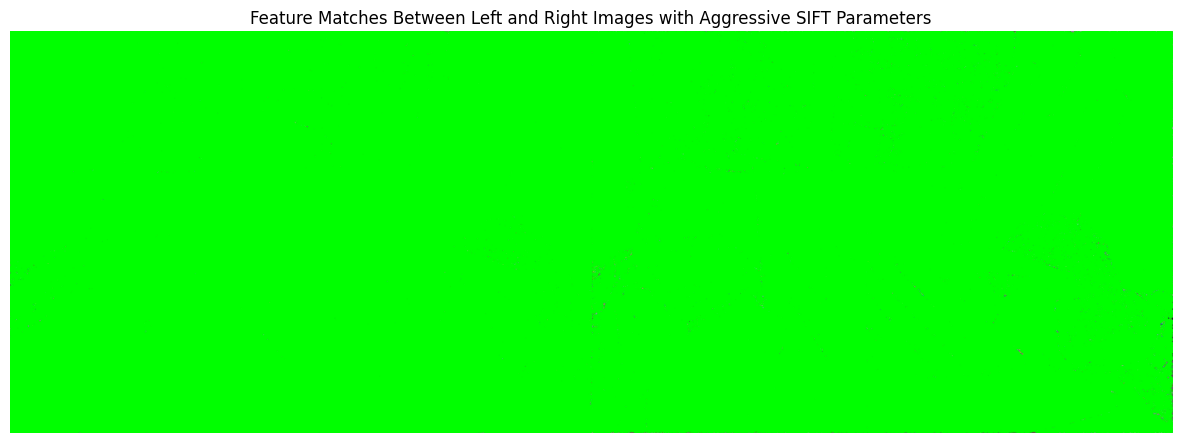

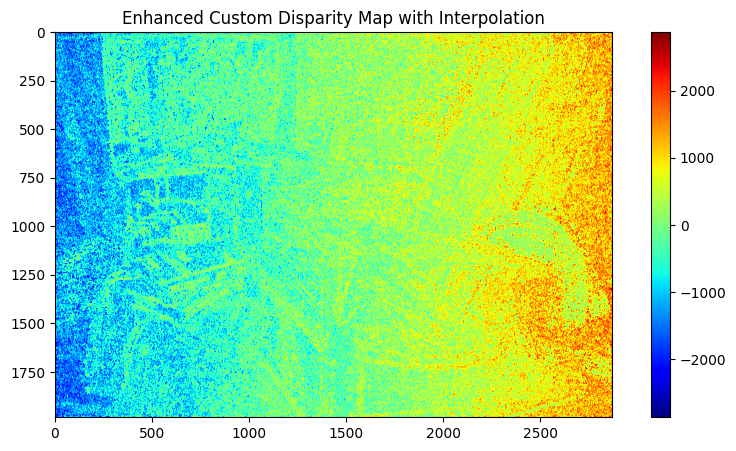

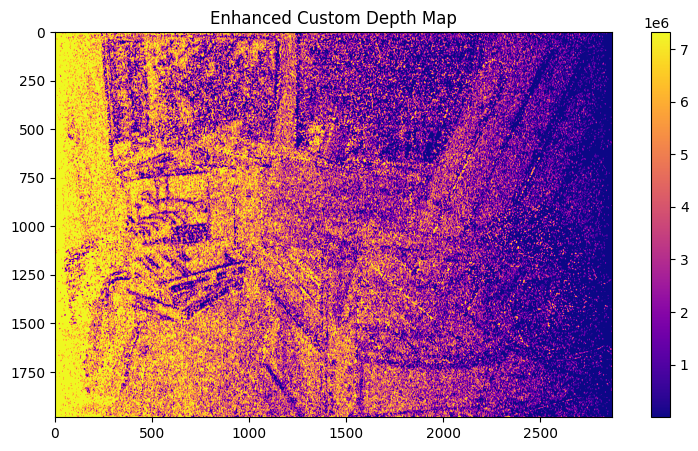

error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/core/include/opencv2/core/utils/buffer_area.private.hpp:70: error: (-215:Assertion failed) count > 0 in function 'allocate'


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Given focal length and baseline
focal_length = 4152.073  # in pixels
baseline = 176.252       # in mm or the same unit

# Load left and right images
left_image = cv2.imread('./Images/im0.png', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('./Images/im1.png', cv2.IMREAD_GRAYSCALE)

if left_image is None or right_image is None:
    raise ValueError("Images not found! Make sure 'im0.png' and 'im1.png' are in the correct directory.")

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(left_image, cmap='gray'), plt.title("Left Image")
plt.subplot(1, 2, 2), plt.imshow(right_image, cmap='gray'), plt.title("Right Image")
plt.show()

def detect_and_match_features(left_image, right_image, use_ratio_test=True):
    # Aggressive SIFT parameters for maximum keypoints
    sift = cv2.SIFT_create(
        # nfeatures=100000,               # Significantly increase number of features
        nOctaveLayers=20,               # More layers per octave for richer detail
        contrastThreshold=0.0001,        # Lower threshold for more keypoints
        edgeThreshold=0.01,               # Reduced further to detect more edge features
        sigma=1.2                      # Adjust sigma for slightly larger features
    )
    
    keypoints_left, descriptors_left = sift.detectAndCompute(left_image, None)
    keypoints_right, descriptors_right = sift.detectAndCompute(right_image, None)

    # FLANN-based matcher with more flexibility
    index_params = dict(algorithm=1, trees=1)  # Lower trees for flexibility
    search_params = dict(checks=200)           # Higher checks for thorough search
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # kNN matching without ratio test for maximum matches
    matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)
    if use_ratio_test:
        good_matches = [m for m, n in matches if m.distance < 0.85 * n.distance]
    else:
        good_matches = [m[0] for m in matches if m]  # Accept all first matches without ratio test

    # Draw matches with larger markers for better visibility
    matched_image = cv2.drawMatches(left_image, keypoints_left, right_image, keypoints_right, good_matches, None,
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Optionally, draw larger circles for better visibility
    for match in good_matches:
        pt_left = tuple(map(int, keypoints_left[match.queryIdx].pt))
        pt_right = tuple(map(int, keypoints_right[match.trainIdx].pt))
        
        # Left image point
        cv2.circle(matched_image, pt_left, 5, (0, 255, 0), thickness=2)
        # Right image point (adjust x coordinate to shift to the right image in drawMatches)
        cv2.circle(matched_image, (pt_right[0] + left_image.shape[1], pt_right[1]), 5, (0, 255, 0), thickness=2)

    return good_matches, keypoints_left, keypoints_right, matched_image

# Feature matching with aggressive parameters and no ratio test
good_matches, keypoints_left, keypoints_right, matched_image = detect_and_match_features(left_image, right_image, use_ratio_test=False)

print("Number of good matches:", len(good_matches))

# Display matched image with enhanced parameters
plt.figure(figsize=(15, 10))
plt.imshow(matched_image)
plt.title("Feature Matches Between Left and Right Images with Aggressive SIFT Parameters")
plt.axis("off")
plt.show()

def calculate_disparity(keypoints_left, keypoints_right, good_matches, image_shape, doffs=0.1, point_size=3):
    disparity_map = np.zeros(image_shape, dtype=np.float32)

    # Calculate disparity for each matched feature
    for match in good_matches:
        xL = int(keypoints_left[match.queryIdx].pt[0])
        yL = int(keypoints_left[match.queryIdx].pt[1])
        xR = int(keypoints_right[match.trainIdx].pt[0])

        # Calculate disparity
        disparity = (xL - xR) + doffs

        # Create a small region around each point to increase visibility
        for dx in range(-point_size, point_size + 1):
            for dy in range(-point_size, point_size + 1):
                if 0 <= xL + dx < image_shape[1] and 0 <= yL + dy < image_shape[0]:
                    disparity_map[yL + dy, xL + dx] = disparity

    # # Interpolation to enhance points for visibility
    # disparity_map = cv2.resize(disparity_map, (disparity_map.shape[1] * 2, disparity_map.shape[0] * 2), interpolation=cv2.INTER_LINEAR)
    # disparity_map = cv2.resize(disparity_map, (image_shape[1], image_shape[0]), interpolation=cv2.INTER_LINEAR)

    # # Optional: Apply smoothing filters
    # disparity_map = cv2.bilateralFilter(disparity_map, 9, 75, 75)
    # disparity_map = cv2.medianBlur(disparity_map, 5)

    return disparity_map

# Calculate the enhanced disparity map with interpolation
disparity_map = calculate_disparity(keypoints_left, keypoints_right, good_matches, left_image.shape)

plt.figure(figsize=(10, 5))
plt.imshow(disparity_map, cmap='jet')
plt.colorbar()
plt.title("Enhanced Custom Disparity Map with Interpolation")
plt.show()

def calculate_depth_map(disparity_map, focal_length, baseline):
    # Ensure no division by zero
    disparity_map[disparity_map <= 0] = 0.1
    depth_map = (focal_length * baseline) / disparity_map
    return depth_map

# Calculate the enhanced depth map
depth_map = calculate_depth_map(disparity_map, focal_length, baseline)

plt.figure(figsize=(10, 5))
plt.imshow(depth_map, cmap='plasma')
plt.colorbar()
plt.title("Enhanced Custom Depth Map")
plt.show()

# Comparison with built-in OpenCV method
def compute_built_in_disparity(left_image, right_image):
    stereo = cv2.StereoSGBM_create(numDisparities=0, blockSize=15)
    disparity_built_in = stereo.compute(left_image, right_image).astype(np.float32) / 16.0
    return disparity_built_in

# Compute disparity with OpenCV's StereoBM
disparity_built_in = compute_built_in_disparity(left_image, right_image)

plt.figure(figsize=(10, 5))
plt.imshow(disparity_built_in, cmap='jet')
plt.colorbar()
plt.title("Built-in Disparity Map")
plt.show()

# Calculate depth from built-in disparity map
depth_map_built_in = calculate_depth_map(disparity_built_in, focal_length, baseline)

# Comparison plots for custom and built-in depth maps
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(depth_map, cmap='plasma')
axs[0].set_title("Enhanced Custom Depth Map")
axs[1].imshow(depth_map_built_in, cmap='plasma')
axs[1].set_title("Built-in Depth Map")
plt.show()